In [2]:
from __future__ import division, print_function

import math

from IPython import display
import PIL.Image

import requests

import sys
if sys.version_info.major == 2:
    from StringIO import StringIO
else:
    from io import StringIO
from io import BytesIO

In [3]:
def get_osm_tile(x, y, z):
    url = 'http://tile.openstreetmap.org/%d/%d/%d.png' % (z, x, y)
    req = requests.get(url)
    if not req.ok:
        req.raise_for_status()
    return req

def deg_xy(lat, lon, zoom):
    lat_rad = math.radians(lat)
    n = 2 ** zoom
    x = int((lon + 180) / 360 * n)
    y = int((1 - math.log(math.tan(lat_rad) + (1 / math.cos(lat_rad))) / math.pi) / 2 * n)
    return x, y

In [4]:
lat, lon = -0.666667, -90.55

pils = []
for zoom in [0, 1, 5, 8]:
    x, y = deg_xy(lat, lon, zoom)
    print(x, y, zoom)
    osm_tile = get_osm_tile(x, y, zoom)
    pil_img = PIL.Image.open(StringIO(osm_tile.content))
    pils.append(pil_img)
composite = PIL.Image.new('RGBA', (520, 520))
composite.paste(pils[0], (0, 0,256, 256))
composite.paste(pils[1], (264, 0, 520, 256))
composite.paste(pils[2], (0, 264, 256, 520))
composite.paste(pils[3], (264, 264, 520, 520))

0 0 0
0 1 1
7 16 5
63 128 8
P (256, 256)


In [5]:
def convert_pil(img):
    b = BytesIO()
    img.save(b, format='png')
    return display.Image(data=b.getvalue())

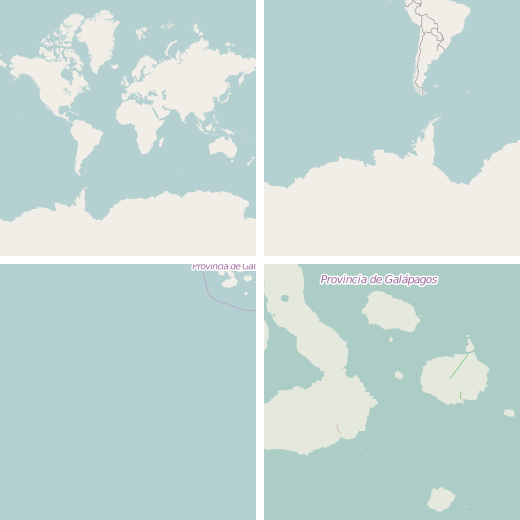

In [6]:
convert_pil(composite)

In [106]:
def get_surrounding(x, y, z, tile_fun):
    composite = PIL.Image.new('RGBA', (768, 768))
    for xi, x_ in enumerate([x - 1, x, x + 1]):
        for yi, y_ in enumerate([y - 1, y, y + 1]):
            tile_req = tile_fun(x_, y_, z)
            pos = (xi * 256, yi * 256, xi * 256 + 256, yi * 256 + 256)
            img = PIL.Image.open(StringIO(tile_req.content))
            composite.paste(img, pos)
    return composite

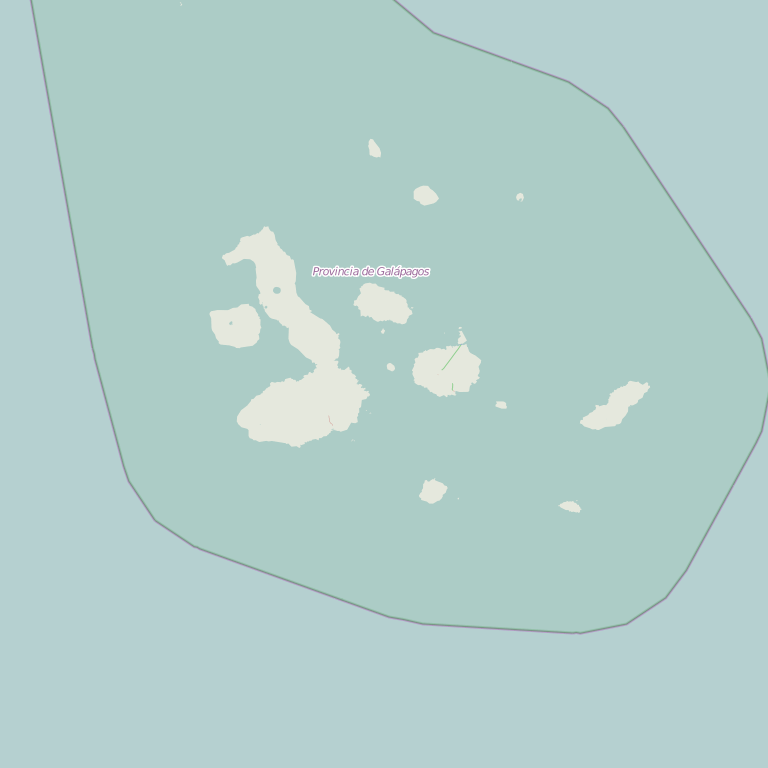

In [112]:
zoom = 8
x, y = deg_xy(lat, lon, zoom)
osm_big = get_surrounding(x, y, zoom, get_osm_tile)
convert_pil(osm_big)

In [48]:
def get_gbif_tile(x, y, z, **kwargs):
    server = 'http://api.gbif.org/v1'
    kwargs['x'] = str(x)
    kwargs['y'] = str(y)
    kwargs['z'] = str(z)
    req = requests.get('%s/map/density/tile' % server,
                       params=kwargs,
                       headers={})
    if not req.ok:
        req.raise_for_status()
    return req

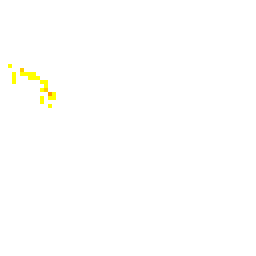

In [129]:
gbif_tile = get_gbif_tile(0, 0, 0, resolution='4',
                       type='TAXON', key='6163845')
#do wee need to add copyright? (both osm and gbif)
img = PIL.Image.open(StringIO(gbif_tile.content))
convert_pil(img)

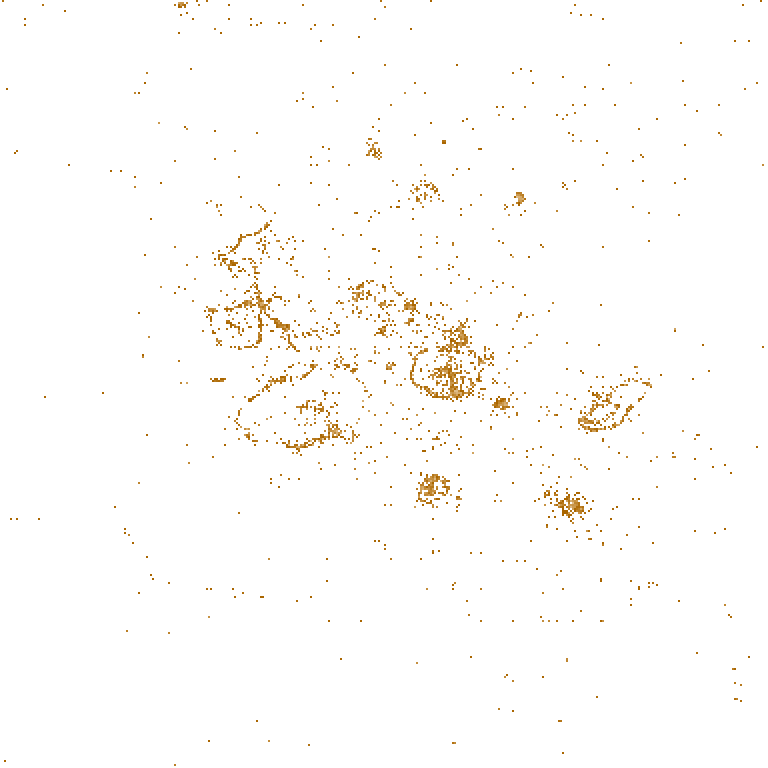

In [149]:
import functools
zoom = 8
x, y = deg_xy(lat, lon, zoom)
gbif_big = get_surrounding(x, y, zoom,
                           functools.partial(get_gbif_tile, hue='0.1',
                                             resolution='2',
                                             saturation='True'))
convert_pil(gbif_big)

In [150]:
compose = PIL.Image.alpha_composite(osm_big, gbif_big)

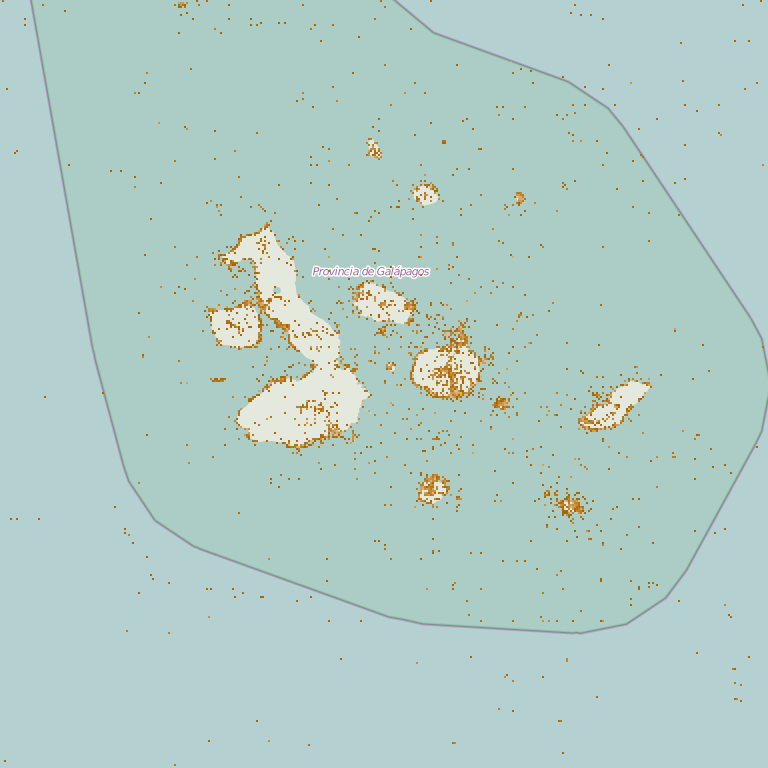

In [151]:
convert_pil(compose)

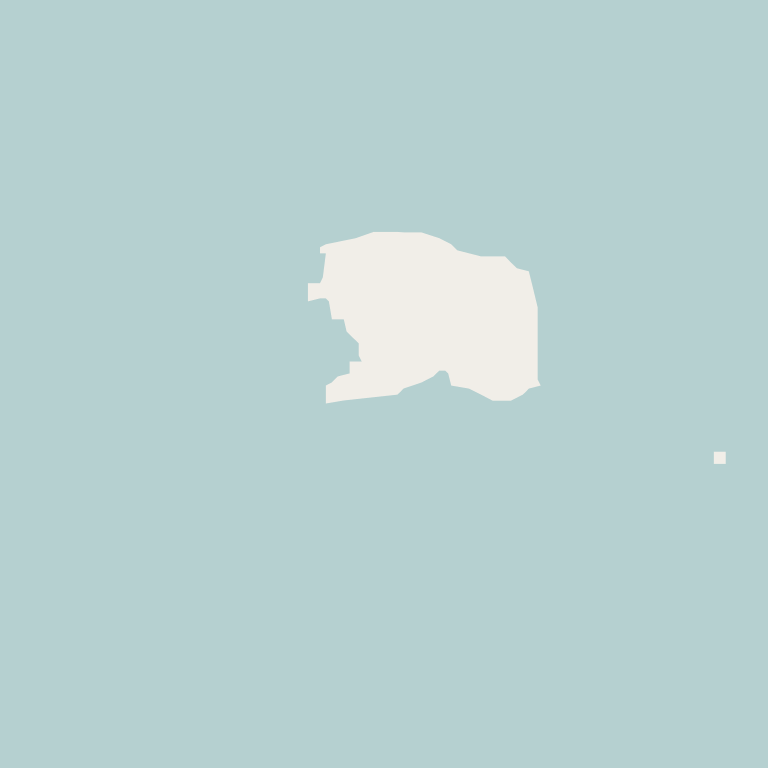

In [154]:
#not on recipe
zoom = 15
x, y = deg_xy(1.6783, -92.0012, zoom)
osm_tile = get_osm_tile(x, y, zoom)
darwin_big = get_surrounding(x, y, zoom, get_osm_tile)
convert_pil(darwin_big)

In [168]:
def do_request(service, a1=None, a2=None, a3=None, **kwargs):
    server = 'http://api.gbif.org/v1'
    params = ''
    for a in [a1, a2, a3]:
        if a is not None:
            params += '/' + a
    req = requests.get('%s/%s%s' % (server, service, params),
                       params=kwargs,
                       headers={'Content-Type': 'application/json'})
    if not req.ok:
        req.raise_for_status()
    return req.json()


def get_all_records(rec_field, service, a1=None, a2=None, a3=None, **kwargs):
    records = []
    all_done = False
    offset = 0
    num_iter = 0
    while not all_done and num_iter < 100:
        req = do_request(service, a1=a1, a2=a2, a3=a3, offset=offset, **kwargs)
        all_done = req['endOfRecords']
        offset += req['limit']
        records.extend(req[rec_field])
        num_iter += 1
    return records

#tighter polygon coordinates
start = 2, -93
end = 1, -91
geom = 'POLYGON(({xi} {yi}, {xf} {yi}, {xf} {yf}, {xi} {yf}, {xi} {yi}))'.format(
    xi=start[1], xf=end[1], yi=start[0], yf=end[0])
print(geom)
recs = get_all_records('results', 'occurrence', 'search', geometry=geom)

POLYGON((-93 2, -91 2, -91 1, -93 1, -93 2))


In [170]:
recs[0]

{u'basisOfRecord': u'HUMAN_OBSERVATION',
 u'catalogNumber': u'diveboard:185444_28519_0',
 u'class': u'Elasmobranchii',
 u'classKey': 121,
 u'collectionCode': u'Diveboard',
 u'country': u'Ecuador',
 u'countryCode': u'EC',
 u'datasetID': u'http://ipt.diveboard.com/resource.do?r=diveboard-occurrences',
 u'datasetKey': u'66f6192f-6cc0-45fd-a2d1-e76f5ae3eab2',
 u'datasetName': u'Diveboard - Scuba diving citizen science',
 u'dateIdentified': u'2012-10-24T22:00:00.000+0000',
 u'day': 25,
 u'decimalLatitude': 1.38367,
 u'decimalLongitude': -91.8111,
 u'depth': 10.19,
 u'depthAccuracy': 10.19,
 u'elevation': 0.0,
 u'elevationAccuracy': 0.0,
 u'eventDate': u'2012-10-25T11:03:00.000+0000',
 u'extensions': {},
 u'facts': [],
 u'family': u'Rhincodontidae',
 u'familyKey': 2198,
 u'gbifID': u'1042460743',
 u'genericName': u'Rhincodon',
 u'genus': u'Rhincodon',
 u'genusKey': 2417521,
 u'geodeticDatum': u'WGS84',
 u'georeferenceSources': u'Google Maps',
 u'identifiedBy': u'Martin Tengelin',
 u'identifi

In [ ]:
#count observations
#count species
#link to species